In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
import warnings
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_csv('/kaggle/input/apple-aapl-historical-stock-data/HistoricalQuotes.csv')

# Data Preprocessing
# Rename columns for easier access
data.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [3]:
# Remove dollar signs and convert columns to numeric
data['Close'] = data['Close'].replace('[\$,]', '', regex=True).astype(float)
data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'Date' column to datetime and sort by date (assuming the data is in descending order)
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.sort_values('Date')

In [4]:
# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Feature Engineering: Adding Moving Averages
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

# Drop any NaN values (from moving averages)
data = data.dropna()

# Data Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close', 'SMA50', 'SMA200', 'Volume']])

In [5]:
# Display the first few rows of the modified data to check the results
print(data.head())

              Close     Volume     Open     High      Low      SMA50  \
Date                                                                   
2010-12-10  45.7943   65576594  45.6643  45.8643  45.5143  44.041824   
2010-12-13  45.9528  109673093  46.3386  46.4371  45.8571  44.153680   
2010-12-14  45.7557   87718986  45.9614  46.0771  45.5714  44.272680   
2010-12-15  45.7657  103780771  45.7143  46.1428  45.5986  44.362452   
2010-12-16  45.8928   80244454  45.8700  46.0871  45.7286  44.454052   

               SMA200  
Date                   
2010-12-10  38.025390  
2010-12-13  38.105876  
2010-12-14  38.185476  
2010-12-15  38.264783  
2010-12-16  38.343739  


In [6]:
# Prepare the training data with a sliding window
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step)])
        y.append(dataset[i + time_step, 0])  # Predicting the "Close" price
    return np.array(X), np.array(y)

# Define time steps and split into training and testing sets
time_step = 60
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [7]:
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Model Building
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dense(1))

In [8]:
# Compile model with mean absolute error metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [9]:
# Training with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0105 - mean_absolute_error: 0.0733 - val_loss: 0.0124 - val_mean_absolute_error: 0.0930
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.5281e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0047 - val_mean_absolute_error: 0.0587
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1413e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0029 - val_mean_absolute_error: 0.0465
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.5288e-04 - mean_absolute_error: 0.0140 - val_loss: 0.0026 - val_mean_absolute_error: 0.0443
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6183e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0013 - val_mean_absolute_error: 0.0294
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9697e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0015 - val_mean_absolute_error: 0.0317
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6769e-04 - mean_absolute_

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train RMSE: 3.6052924618695275
Test RMSE: 7.517013495854843
Test MAE: 5.588290542415713


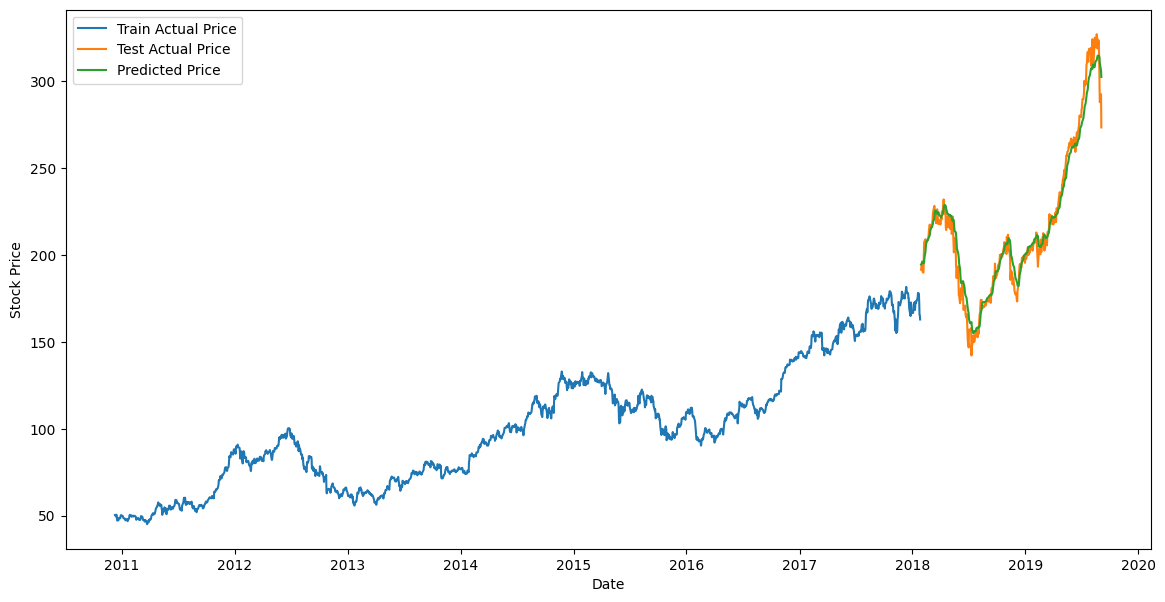

In [10]:
# Prediction and Rescaling
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Rescale predictions back to original scale
train_predict = scaler.inverse_transform(np.hstack((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1)))))
test_predict = scaler.inverse_transform(np.hstack((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1)))))
y_train_rescaled = scaler.inverse_transform(np.hstack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], scaled_data.shape[1] - 1)))))
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)))))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(y_train_rescaled[:, 0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, 0], test_predict[:, 0]))
test_mae = mean_absolute_error(y_test_rescaled[:, 0], test_predict[:, 0])

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

# Visualization of Predictions
plt.figure(figsize=(14, 7))
plt.plot(data.index[:len(y_train_rescaled)], y_train_rescaled[:, 0], label='Train Actual Price')
plt.plot(data.index[len(y_train_rescaled):(len(y_train_rescaled) + len(y_test_rescaled))], y_test_rescaled[:, 0], label='Test Actual Price')
plt.plot(data.index[len(y_train_rescaled):(len(y_train_rescaled) + len(test_predict))], test_predict[:, 0], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [11]:
# Define a function to calculate percentage accuracy within a tolerance
def accuracy_within_tolerance(y_true, y_pred, tolerance=0.05):
    # Avoid division by zero by filtering out zero values in y_true
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    within_tolerance = np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered) <= tolerance
    accuracy = np.mean(within_tolerance) * 100
    return accuracy

# Calculate train and test accuracy within a tolerance of ±5%
train_accuracy = accuracy_within_tolerance(y_train, model.predict(X_train))
test_accuracy = accuracy_within_tolerance(y_test, model.predict(X_test))

# Display metrics
print(f"Train Accuracy within ±5% tolerance: {train_accuracy:.2f}%")
print(f"Test Accuracy within ±5% tolerance: {test_accuracy:.2f}%")


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train Accuracy within ±5% tolerance: 4.25%
Test Accuracy within ±5% tolerance: 14.38%


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


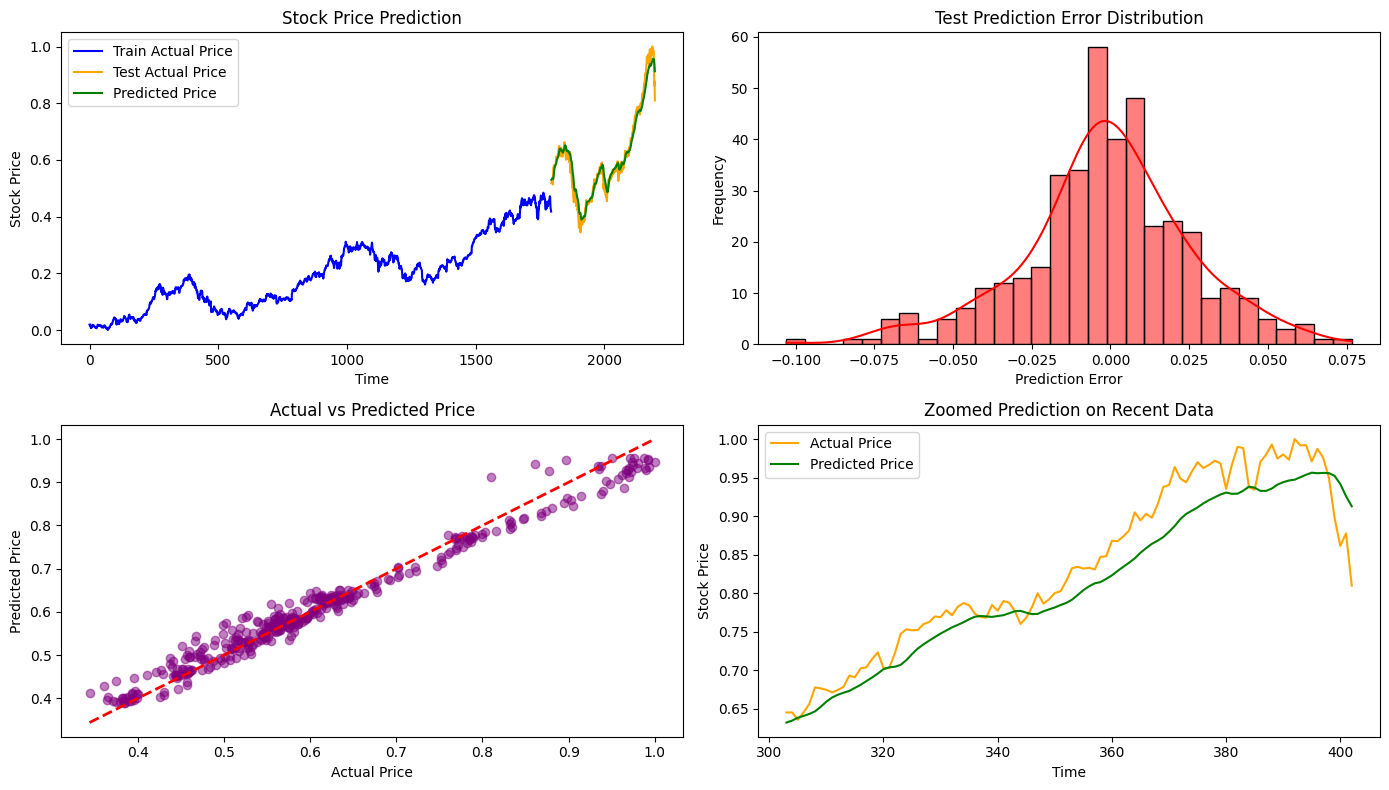

In [12]:
# Suppress FutureWarning about use_inf_as_na
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Predictions on the training and testing data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Calculate errors
train_errors = y_train - train_predict.ravel()
test_errors = y_test - test_predict.ravel()

# Replace infinities with NaN
train_errors = np.where(np.isinf(train_errors), np.nan, train_errors)
test_errors = np.where(np.isinf(test_errors), np.nan, test_errors)

# Plotting
plt.figure(figsize=(14, 8))

# 1. Full Prediction Plot
plt.subplot(2, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Train Actual Price", color='blue')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label="Test Actual Price", color='orange')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_predict, label="Predicted Price", color='green')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.legend()

# 2. Error Distribution Plot
plt.subplot(2, 2, 2)
sns.histplot(test_errors[~np.isnan(test_errors)], kde=True, color='red', bins=30)  # Ignore NaN values in the plot
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Test Prediction Error Distribution")

# 3. Scatter Plot of Predicted vs Actual
plt.subplot(2, 2, 3)
plt.scatter(y_test, test_predict, color='purple', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")

# 4. Zoomed Plot on Recent Data (last 100 data points in test set)
plt.subplot(2, 2, 4)
plt.plot(range(len(y_test) - 100, len(y_test)), y_test[-100:], label="Actual Price", color='orange')
plt.plot(range(len(y_test) - 100, len(y_test)), test_predict[-100:], label="Predicted Price", color='green')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Zoomed Prediction on Recent Data")
plt.legend()

plt.tight_layout()
plt.show()